In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END, START
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver

In [3]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
class JokeState(TypedDict):
    topic: str
    joke: str
    exp: str

In [5]:
def gen_func(state: JokeState):

    prompt = f"Generate a joke on the following topic: {state["topic"]}"
    response = llm.invoke(prompt)
    return {"joke":response.content}

In [6]:
def exp_func(state: JokeState):

    prompt = f"Explain the following joke: {state["joke"]}"
    response = llm.invoke(prompt)
    return {"exp":response.content}

In [14]:
graph = StateGraph(JokeState)

graph.add_node("gen",gen_func)
graph.add_node("exp",exp_func)

graph.add_edge(START,"gen")
graph.add_edge("gen","exp")
graph.add_edge("exp",END)
checkpointer = InMemorySaver()
workflow = graph.compile(checkpointer=checkpointer)

In [ ]:
j = "Indian media"
config1 = {"configurable":{"thread_id":"1"}}
result = workflow.invoke({"topic":j},config=config1)

In [17]:
result

{'topic': 'AI',
 'joke': 'Why did the AI break up with its human girlfriend?\n\nIt said she had too many "unstructured data points" in her emotional responses.',
 'exp': 'This joke plays on the fundamental differences between how Artificial Intelligence (AI) processes information and how human emotions work.\n\nHere\'s the breakdown:\n\n1.  **"Unstructured Data Points":**\n    *   **In AI/Computer Science:** "Unstructured data" refers to information that doesn\'t have a pre-defined data model or isn\'t organized in a pre-defined manner. Think of things like text documents, emails, social media posts, images, audio files, or video. It\'s messy, lacks consistent formatting, and is hard for a computer to parse without advanced techniques.\n    *   **In contrast, "structured data"** is highly organized and formatted, like data in a spreadsheet or database, with clear rows, columns, and categories. AI excels at processing structured data.\n\n2.  **Applying it to Human Emotions:**\n    *   H

In [18]:
workflow.get_state(config=config1)

StateSnapshot(values={'topic': 'AI', 'joke': 'Why did the AI break up with its human girlfriend?\n\nIt said she had too many "unstructured data points" in her emotional responses.', 'exp': 'This joke plays on the fundamental differences between how Artificial Intelligence (AI) processes information and how human emotions work.\n\nHere\'s the breakdown:\n\n1.  **"Unstructured Data Points":**\n    *   **In AI/Computer Science:** "Unstructured data" refers to information that doesn\'t have a pre-defined data model or isn\'t organized in a pre-defined manner. Think of things like text documents, emails, social media posts, images, audio files, or video. It\'s messy, lacks consistent formatting, and is hard for a computer to parse without advanced techniques.\n    *   **In contrast, "structured data"** is highly organized and formatted, like data in a spreadsheet or database, with clear rows, columns, and categories. AI excels at processing structured data.\n\n2.  **Applying it to Human Emo

In [20]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'AI', 'joke': 'Why did the AI break up with its human girlfriend?\n\nIt said she had too many "unstructured data points" in her emotional responses.', 'exp': 'This joke plays on the fundamental differences between how Artificial Intelligence (AI) processes information and how human emotions work.\n\nHere\'s the breakdown:\n\n1.  **"Unstructured Data Points":**\n    *   **In AI/Computer Science:** "Unstructured data" refers to information that doesn\'t have a pre-defined data model or isn\'t organized in a pre-defined manner. Think of things like text documents, emails, social media posts, images, audio files, or video. It\'s messy, lacks consistent formatting, and is hard for a computer to parse without advanced techniques.\n    *   **In contrast, "structured data"** is highly organized and formatted, like data in a spreadsheet or database, with clear rows, columns, and categories. AI excels at processing structured data.\n\n2.  **Applying it to Human Em

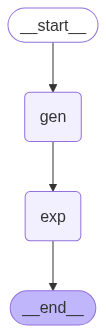

In [8]:
workflow